In [68]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date, datetime
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from tqdm import tqdm

### Downloading historical data for Apple Inc. (AAPL), and Google LLC (GOOGL),  Microsoft Corp. (MSFT) to files
Technological industry is strongly related, so we need information about Apple and Google price to be able to predict MSFT price movement better
    

In [69]:
#Downloading historical data for Apple Inc. (AAPL), Microsoft Corp. (MSFT), and Google LLC (GOOGL) to files

tickers = ['AAPL', 'GOOGL', 'MSFT']

for share in tickers:
    share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
    
    if isinstance(share_data.columns, pd.MultiIndex):
        share_data.columns = share_data.columns.get_level_values(0)
        
    share_data.reset_index(inplace=True)    
    share_data.rename(columns={'Date':'DATE'}, inplace=True)    
    columns = share_data.columns
    columns = columns[1:]
    
    for c in columns:
        share_data.rename(columns={c: c + '_' + share}, inplace=True)
    share_data.to_csv(f'prices/historical_{share}_data.csv', index=False)
    print('*' * 18, {share}, '*' * 18)
    print(share_data.head(3))
    print('*' * 40)

/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_35063/1410415989.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_35063/1410415989.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_35063/1410415989.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))


****************** {'AAPL'} ******************
Price       DATE  Close_AAPL  High_AAPL  Low_AAPL  Open_AAPL  Volume_AAPL
0     2000-01-03    0.839281   0.843498  0.762428   0.786328    535796800
1     2000-01-04    0.768521   0.829440  0.758680   0.811633    512377600
2     2000-01-05    0.779767   0.828971  0.772269   0.777892    778321600
****************************************
****************** {'GOOGL'} ******************
Price       DATE  Close_GOOGL  High_GOOGL  Low_GOOGL  Open_GOOGL  Volume_GOOGL
0     2004-08-19     2.492181    2.584576   2.383393    2.483736     893181924
1     2004-08-20     2.690134    2.709260   2.496155    2.508822     456686856
2     2004-08-23     2.717207    2.818544   2.708514    2.750738     365122512
****************************************


[*********************100%***********************]  1 of 1 completed


****************** {'MSFT'} ******************
Price       DATE  Close_MSFT  High_MSFT   Low_MSFT  Open_MSFT  Volume_MSFT
0     2000-01-03   35.601448  36.231393  34.207933  35.849608     53228400
1     2000-01-04   34.398842  35.773268  34.284306  34.685181     54119000
2     2000-01-05   34.761524  35.544183  33.406187  33.940686     64059600
****************************************


### Calculate RSI, MACD, ATR, Bolliner Bands 
They tell us about:
- **RSI:** It calculates the speed and changes of price movement  
        If RSI > 70 => stock is bought out  
        If RSI < 30 => stock is sold out  
        
- **MACD:** It shows us the relation between two moving averages of price  
        -> **MACD_12_26_9** is the main indicator line 
             - (val >0) suggests increasing trend  
             - (val <0) suggest decreasing trend   
        -> **MACDs_12_26_9** is a signal line, it's the moving averege of MACD_12_26_9     
              - It doesn't tell us much, but it's relation with MACD_12_26_9 is the most important  
        -> **MACDh_12_26_9** is a histogram of the difference between MACD line and it's signal line  
            - (val > 0): the growth momentum is accelerating
            - (val < 0): downward momentum dominates
            
- **ATR:** It measures stock market variability  
    the higher value of ATR the more stock price was variable last 14 days
  
- **Bolliger Bands:** It defines the range in which the price usually moves  
    -> ** BBM_20_2.0 - Middle band:  
        It's a 20-day simple moving average (SMA) of the closing price.
    -> **BBU_20_2.0** - Upper band: it's the BBM + 2σ  
        It acts as dynamic resistance. Statistically, the price rarely stays above this line  
    -> **BBL_20_2.0** - Lower band: it's the BBM - 2σ  
        It acts like dynamic support  
    -> **BBB_20_2.0** - Band width: 
        It's a percent diversity between upper and lower bands:  
        - High BBB means that market is very volatile and stock's price movements are very nervous at the moment  
    -> **BBP_20_2.0** - %B indicator
    If:
        - value = 1.0: The price is exactly on Upper band   
        - value = 0.5: The price is exactly on Middle band  
        - value = 0.0: The price is exactly on Lower band  
        - value > 1.0: The price has broken the Upper band  
        - value < 0.0:  The price has broken the Lower band

In [70]:
for share in tickers:
    stock_data = pd.read_csv(f'prices/historical_{share}_data.csv')
    
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = stock_data.columns.get_level_values(0)
        
    ### RSI
    stock_data.ta.rsi(length=14, append=True)
    
    
    ### MACD
    stock_data.ta.macd(fast=12, slow=26, signal=9, append=True)
    
    ### ATR 
    stock_data.ta.atr(length=14, append=True)
    
    ### Bollinger Bands
    stock_data.ta.bbands(length=20,std=2, append=True)
    
    
    stock_data.to_csv(f'stock market data/ {share}_data.csv', index=False)


## Loading Macroeconomic data : 


### - FEDFUNDS - Fed Funds Rate (pol: Stopy procentowe):  
    - High interest rates typically hurt technology companies because they reduce the value of future earnings and increase borrowing costs


        DATE  FEDFUNDS
0 2000-01-01      5.45
1 2000-02-01      5.73
2 2000-03-01      5.85
3 2000-04-01      6.02
4 2000-05-01      6.27


Text(0.5, 1.0, 'Fed Funds Rate')

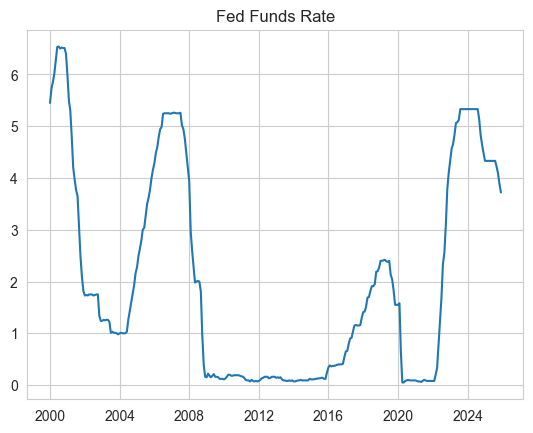

In [71]:
## Loading macro economic data
### need to install pandas-datareader 

### Fed Funds Rate (pol: Stopy procentowe)

FEDFUNDS = web.DataReader('FEDFUNDS', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
FEDFUNDS.reset_index(inplace=True)

print(FEDFUNDS.head())
FEDFUNDS.to_csv('Macroeconomic data/ FEDFUNDS.csv', index=False)

plt.plot(FEDFUNDS['DATE'], FEDFUNDS['FEDFUNDS'])
plt.title('Fed Funds Rate')
                               

### - DGS10 -  Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (pol: Rentowność Obligacji 10-letnich):  
    -The increase in bond yields often causes capital to flow out of stocks into safer bonds.


        DATE  DGS10
0 2000-01-03   6.58
1 2000-01-04   6.49
2 2000-01-05   6.62
3 2000-01-06   6.57
4 2000-01-07   6.52


Text(0.5, 1.0, 'DGS10')

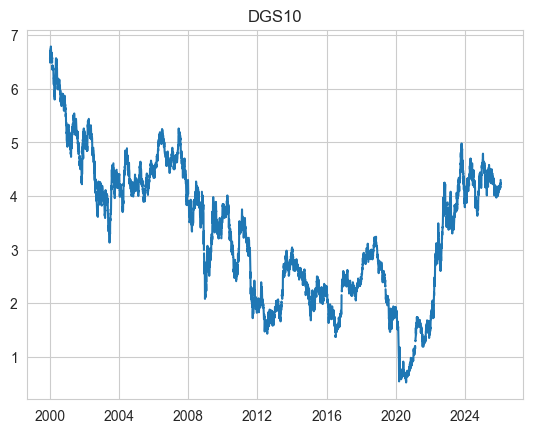

In [72]:
### Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (pol: Rentowność Obligacji 10-letnich)

DGS10 = web.DataReader('DGS10', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
DGS10.reset_index(inplace=True)
print(DGS10.head())
DGS10.to_csv('Macroeconomic data/ DGS10.csv', index=False)
plt.plot(DGS10['DATE'], DGS10['DGS10'])
plt.title('DGS10')

### - CPI - Inflation Indicator (pol: Wskaźnik Inflacji)
    - High inflation could force the Fed to raise interest rates, which would indirectly hurt stock's valuation. On the other hand, stock with a strong market position can pass on costs to customers (pricing power).

        DATE    CPI
0 2000-01-01  169.3
1 2000-02-01  170.0
2 2000-03-01  171.0
3 2000-04-01  170.9
4 2000-05-01  171.2
5 2000-06-01  172.2
6 2000-07-01  172.7
7 2000-08-01  172.7
8 2000-09-01  173.6
9 2000-10-01  173.9


Text(0.5, 1.0, 'CPI')

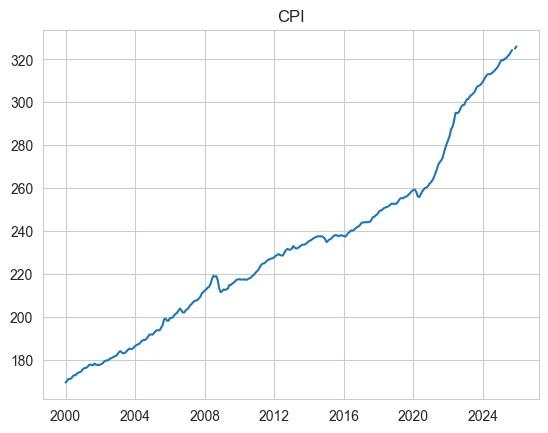

In [73]:
### CPI (pol: Wskaznik inflacji)

CPI = web.DataReader("CPIAUCSL", 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
CPI.reset_index(inplace=True)
CPI.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
print(CPI.head(10))
CPI.to_csv('Macroeconomic data/ CPI.csv', index=False)
plt.plot(CPI['DATE'], CPI['CPI'])
plt.title('CPI')

### - Dollar index (pol: Indeks dollara):  
    -A strong dollar (high index) means that foreign profits are lower when converted into dollars, which negatively affects the company's financial results.


        DATE  Dollar_idx
0 2006-01-02    101.4155
1 2006-01-03    100.7558
2 2006-01-04    100.2288
3 2006-01-05    100.2992
4 2006-01-06    100.0241
5 2006-01-09    100.1794
6 2006-01-10    100.1436
7 2006-01-11     99.8710
8 2006-01-12    100.0643
9 2006-01-13     99.9675


Text(0.5, 1.0, 'Dollar Index')

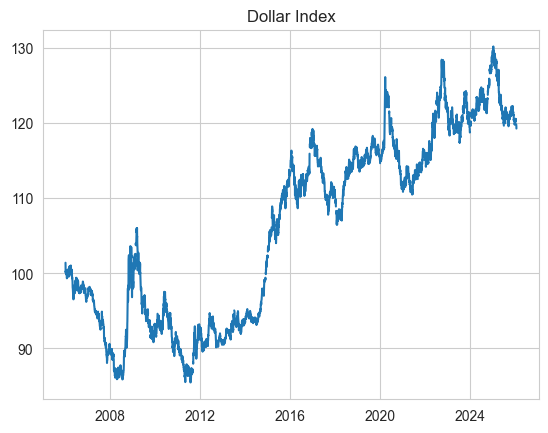

In [74]:
### Dollar index 

Dollar_idx = web.DataReader('DTWEXBGS', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
Dollar_idx.reset_index(inplace=True)
Dollar_idx.rename(columns={'DTWEXBGS': 'Dollar_idx'}, inplace=True)
print(Dollar_idx.head(10))
Dollar_idx.to_csv('Macroeconomic data/ Dollar_idx.csv', index=False)
plt.plot(Dollar_idx['DATE'], Dollar_idx['Dollar_idx'])
plt.title('Dollar Index')


Text(0.5, 1.0, 'All Macroeconomic datasets plots')

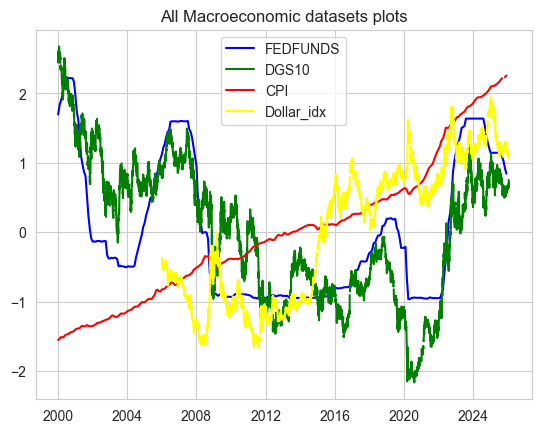

In [75]:
### Setting the same data time for all data

macroeconomic_datasets = [FEDFUNDS, DGS10, CPI, Dollar_idx]
labels = ['FEDFUNDS', 'DGS10', 'CPI', 'Dollar_idx']
plot_colors = ['blue', 'green', 'red', 'yellow', 'black']
scaler = StandardScaler()

for idx, dataset in enumerate(macroeconomic_datasets):
    dataset.sort_values('DATE', inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    dataset[labels[idx] + "_scaled"] = scaler.fit_transform(dataset[[labels[idx]]])
    plt.plot(dataset['DATE'], dataset[labels[idx] + '_scaled'], color=plot_colors[idx])
    dataset.drop(labels[idx] + '_scaled', inplace=True, axis=1)
plt.legend(labels)
plt.title('All Macroeconomic datasets plots')



### VIX - FEAR INDEX:

   VIX < 20-> Relative calm on the stock market  
   VIX 20 - 30 -> Increased volatility, uncertainty  
   VIX > 30 -> Panic on the stock market   

In [76]:
## FEAR INDEX

start_date = datetime(year=2000, month=1, day=1)
end_date = date.today().strftime('%Y-%m-%d')
fear_idx = yf.download(tickers= '^VIX',
                   start=start_date,
                   end=end_date,
                   auto_adjust=True,
                   progress=False,
                   interval="1d")
fear_idx.columns = [col[0] for col in fear_idx.columns]
fear_idx = pd.DataFrame(fear_idx)
fear_idx['VIX_percent'] = fear_idx['Close'].pct_change()
fear_idx.dropna(inplace=True)
fear_idx['Is_Panic'] = (fear_idx['Close'] > 30).astype(int)
fear_idx['Is_Calm'] = (fear_idx['Close'] < 20).astype(int)
fear_idx['Is_Uncertain'] = ((fear_idx['Close'] >= 20) & (fear_idx['Close'] <= 30)).astype(int)

fear_idx.reset_index(inplace=True)
fear_idx.rename(columns={'Date':'DATE'}, inplace=True)
fear_idx.to_csv('fear and sentiment data/ fear_idx.csv', index=False)
fear_idx.head()

,DATE,Close,High,Low,Open,Volume,VIX_percent,Is_Panic,Is_Calm,Is_Uncertain
0,2000-01-04,27.010000,27.180000,24.799999,24.940001,0,0.115655,0,0,1
1,2000-01-05,26.410000,29.000000,25.850000,27.980000,0,-0.022214,0,0,1
2,2000-01-06,25.730000,26.709999,24.700001,26.680000,0,-0.025748,0,0,1
3,2000-01-07,21.719999,25.170000,21.719999,25.139999,0,-0.155849,0,0,1
4,2000-01-10,21.709999,22.490000,21.360001,21.889999,0,-0.000460,0,0,1


### FINANCIAL NEWS SENTIMENT
-    It measures uncertainty of the economic policy  
      High uncertainty causes investors to avoid risk, which may hinder price growth in technology stocks.

In [77]:
### FINANCIAL NEWS

financial_sentiment = web.DataReader('USEPUINDXD', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
financial_sentiment.reset_index(inplace=True)
print(financial_sentiment.head())
financial_sentiment.to_csv('fear and sentiment data/ financial_sentiment.csv', index=False)

        DATE  USEPUINDXD
0 2000-01-01       68.04
1 2000-01-02      119.36
2 2000-01-03       35.73
3 2000-01-04      109.31
4 2000-01-05      123.22


In [78]:
import kagglehub
import pandas as pd
import os

output_dir = 'fear and sentiment data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def download_and_process(dataset_name, output_filename):
    path_folder = kagglehub.dataset_download(dataset_name)
    files = os.listdir(path_folder)
    csv_file = next((f for f in files if f.endswith('.csv')), None)
    
    if csv_file:
        full_path = os.path.join(path_folder, csv_file)        
        df = pd.read_csv(full_path)
        print(df.head())
        
        save_path = os.path.join(output_dir, output_filename)
        df.to_csv(save_path, index=False)

download_and_process(
    "emrekaany/google-googl-financial-news-from-2000-to-today",
    "googl_news_kaggle.csv"
)

download_and_process(
    "frankossai/apple-stock-aapl-historical-financial-news-data",
    "aapl_news_kaggle.csv"
)

  category    datetime                                           headline  \
0  company  1745449200  Alphabet earnings, Fed comments, Nintendo Swit...   
1  company  1745446095  Is Alphabet Inc. (GOOGL) the Best Stock to Buy...   
2  company  1745442355  Is Alphabet Inc. (GOOG) the Best Stock to Buy ...   
3  company  1745440328  Google earnings are coming today. Here's what ...   
4  company  1745439372  Equity Markets Close Higher Over Potential Red...   

          id                                              image related  \
0  134059226  https://s.yimg.com/rz/stage/p/yahoo_finance_en...   GOOGL   
1  134059227  https://s.yimg.com/rz/stage/p/yahoo_finance_en...   GOOGL   
2  134059228  https://s.yimg.com/rz/stage/p/yahoo_finance_en...   GOOGL   
3  134059229  https://s.yimg.com/rz/stage/p/yahoo_finance_en...   GOOGL   
4  134059230  https://s.yimg.com/rz/stage/p/yahoo_finance_en...   GOOGL   

  source                                            summary  \
0  Yahoo  Here's what i

In [79]:
sent_pipeline = pipeline('sentiment-analysis', model='ProsusAI/finbert')

def calculate_daily_sentiment(headlines):
    if not headlines or len(headlines) == 0:
        return 0.0
    results = sent_pipeline(headlines, truncation=True, max_length=512)
    scores = []
    for res in results:
        score = res['score']
        if res['label'] == 'negative': score = -score
        elif res['label'] == 'neutral': score = 0.0
        scores.append(score)
    return np.mean(scores)

def get_hybrid_sentiment_df(ticker, historical_csv_path=None):
    all_news = []
    
    if historical_csv_path and os.path.exists(historical_csv_path):
        hist_df = pd.read_csv(historical_csv_path)
   
        if 'datetime' in hist_df.columns:
            hist_df['DATE'] = pd.to_datetime(hist_df['datetime'], unit='s')
                
            if 'headline' in hist_df.columns:
                hist_df = hist_df.rename(columns={'headline': 'Headline'})
            
        else:
            hist_df = hist_df.rename(columns={
                    'date': 'DATE', 'Date': 'DATE',
                    'title': 'Headline', 'Title': 'Headline', 'article_title': 'Headline'
                })
            if 'DATE' in hist_df.columns:
                hist_df['DATE'] = pd.to_datetime(hist_df['DATE'], errors='coerce')

        if 'DATE' in hist_df.columns and 'Headline' in hist_df.columns:
            hist_df = hist_df.dropna(subset=['DATE', 'Headline'])
                
            hist_df['DATE'] = hist_df['DATE'].dt.tz_localize(None).dt.normalize()
                
            news_data = hist_df[['DATE', 'Headline']].to_dict('records')
            all_news.extend(news_data)
        
    yf_news = yf.Ticker(ticker).news
    if yf_news:
        for item in yf_news:
            ts = item.get('providerPublishTime', 0)
            date_obj = datetime.fromtimestamp(ts).replace(hour=0, minute=0, second=0, microsecond=0)
            all_news.append({'DATE': date_obj, 'Headline': item.get('title', '')})


    news_df = pd.DataFrame(all_news)
    
    if news_df.empty:
        return pd.DataFrame(columns=['DATE', 'FinBERT_Score', 'FinBERT_MA7'])
    
    news_df['DATE'] = pd.to_datetime(news_df['DATE'])
    
    news_df = news_df.drop_duplicates(subset=['DATE', 'Headline'])
    
    
    tqdm.pandas()
    
    daily_sent = news_df.groupby('DATE')['Headline'].progress_apply(list).apply(calculate_daily_sentiment).reset_index()
    daily_sent.columns = ['DATE', 'FinBERT_Score']
    
    daily_sent = daily_sent.sort_values('DATE')
    daily_sent['FinBERT_MA7'] = daily_sent['FinBERT_Score'].rolling(7, min_periods=1).mean().fillna(0)
    
    return daily_sent

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1644.51it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


### WIDE STOCK MARKET

In [80]:
SP500 = yf.download('SPY', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
if isinstance(SP500.columns, pd.MultiIndex):
    SP500.columns = SP500.columns.get_level_values(0)
        
SP500.reset_index(inplace=True)    
SP500.rename(columns={'Date':'DATE'}, inplace=True)    
columns = SP500.columns
columns = columns[1:]
    
for c in columns:
    SP500.rename(columns={c: c + '_SP500'}, inplace=True)
SP500.to_csv(f'prices/historical_SP500_data.csv', index=False)
print(SP500.head())


/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_35063/66001378.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  SP500 = yf.download('SPY', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

Price       DATE  Close_SP500  High_SP500  Low_SP500  Open_SP500  Volume_SP500
0     2000-01-03    91.617043   93.388752  90.632760   93.388752       8164300
1     2000-01-04    88.034286   90.750908  87.965387   90.416252       8089800
2     2000-01-05    88.191719   89.156316  86.459382   88.152348      12177900
3     2000-01-06    86.774368   89.136647  86.774368   87.955508       6227200
4     2000-01-07    91.813927   91.813927  88.231136   88.388622       8066500


In [81]:
GOOGL = pd.read_csv('stock market data/ GOOGL_data.csv')
AAPL = pd.read_csv('stock market data/ AAPL_data.csv')
MSFT = pd.read_csv('stock market data/ MSFT_data.csv')
SP500 = pd.read_csv('prices/historical_SP500_data.csv')

kaggle_files = {
    'GOOGL': 'fear and sentiment data/googl_news_kaggle.csv',
    'AAPL': 'fear and sentiment data/aapl_news_kaggle.csv',
    'MSFT': None 
}

stock_dfs = {
    'MSFT': MSFT,
    'AAPL': AAPL,
    'GOOGL': GOOGL
}

for share in stock_dfs.keys():
    main_share = stock_dfs[share].copy()
    
    main_share['DATE'] = pd.to_datetime(main_share['DATE']).dt.tz_localize(None).dt.normalize()
    
    csv_path = kaggle_files.get(share)
    
    sentiment_df = get_hybrid_sentiment_df(share, csv_path)
    
    if not sentiment_df.empty:
        sentiment_df['DATE'] = pd.to_datetime(sentiment_df['DATE']).dt.tz_localize(None).dt.normalize()
        
        main_share = pd.merge(main_share, sentiment_df, on='DATE', how='left')
        
        matched = main_share['FinBERT_Score'].notna().sum()
        
        main_share['FinBERT_Score'] = main_share['FinBERT_Score'].fillna(0)
        main_share['FinBERT_MA7'] = main_share['FinBERT_MA7'].fillna(0)
    else:
        main_share['FinBERT_Score'] = 0.0
        main_share['FinBERT_MA7'] = 0.0

    datasets = [FEDFUNDS, DGS10, CPI, Dollar_idx, financial_sentiment, fear_idx, SP500]
    data = main_share.copy() 
        
    for other_share in stock_dfs.keys():
        if other_share != share:
            try:
                od = pd.read_csv(f'stock market data/ {other_share}_data.csv')
                od['DATE'] = pd.to_datetime(od['DATE']).dt.tz_localize(None).dt.normalize()
                od = od.add_suffix(f'_{other_share}').rename(columns={f'DATE_{other_share}': 'DATE'})
                datasets.append(od)
            except: pass
                
    for dataset in datasets:
        if 'DATE' in dataset.columns:
            dataset['DATE'] = pd.to_datetime(dataset['DATE']).dt.tz_localize(None).dt.normalize()
            data = pd.merge(data, dataset, on='DATE', how='left')
    
    if 'FinBERT_Score' in data.columns:
        data['FinBERT_Score'] = data['FinBERT_Score'].ffill()
        data['FinBERT_Score'] = data['FinBERT_Score'].fillna(0)
        data['FinBERT_MA7'].ffill(inplace=True)
        data['FinBERT_MA7'] = data['FinBERT_MA7'].fillna(0)
    data = data.ffill()
    data.dropna(inplace=True)
    
    features = [col for col in data.columns if col not in ['Target', 'DATE']]
    data[features] = data[features].shift(1) 
    data.dropna(inplace=True)

    
    data.to_csv(f"all_data/all_{share}_data.csv", index=False)
    
    stock_dfs[share] = data
    print(stock_dfs[share].head())

100%|██████████| 1/1 [00:00<00:00, 1653.25it/s]
/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_35063/944676343.py:60: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object.


  data['FinBERT_MA7'].ffill(inplace=True)


           DATE  Close_MSFT  High_MSFT   Low_MSFT  Open_MSFT  Volume_MSFT  \
1509 2006-01-04   18.715061  18.826626  18.199072  18.303664   79973000.0   
1510 2006-01-05   18.805706  18.882408  18.666250  18.666250   57975600.0   
1511 2006-01-06   18.819651  18.917270  18.763868  18.798732   48245500.0   
1512 2006-01-09   18.763868  18.826624  18.471010  18.749922  100963000.0   
1513 2006-01-10   18.729008  18.875436  18.659279  18.777817   55625000.0   

         RSI_14  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  ...  \
1509  48.943900     -0.142176      -0.059183      -0.082993  ...   
1510  51.922409     -0.115401      -0.025926      -0.089475  ...   
1511  52.382629     -0.091996      -0.002017      -0.089979  ...   
1512  50.308030     -0.077060       0.010335      -0.087395  ...   
1513  49.001910     -0.067261       0.016107      -0.083368  ...   

      RSI_14_GOOGL  MACD_12_26_9_GOOGL  MACDh_12_26_9_GOOGL  \
1509     62.432139            0.193956            -0.037985   
15

100%|██████████| 1575/1575 [00:00<00:00, 68371.94it/s]
/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_35063/944676343.py:60: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object.


  data['FinBERT_MA7'].ffill(inplace=True)


           DATE  Close_AAPL  High_AAPL  Low_AAPL  Open_AAPL  Volume_AAPL  \
1509 2006-01-04    2.241830   2.241830  2.166852   2.170751  807234400.0   
1510 2006-01-05    2.248428   2.278719  2.234332   2.253227  619603600.0   
1511 2006-01-06    2.230735   2.246330  2.211841   2.244231  449422400.0   
1512 2006-01-09    2.288316   2.300313  2.235832   2.256826  704457600.0   
1513 2006-01-10    2.280818   2.315308  2.271521   2.301212  675040800.0   

         RSI_14  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  ...  \
1509  63.192569      0.052154      -0.013956       0.066110  ...   
1510  63.759213      0.053152      -0.010367       0.063518  ...   
1511  61.045357      0.051916      -0.009282       0.061198  ...   
1512  66.102186      0.054950      -0.004998       0.059948  ...   
1513  64.920219      0.056103      -0.003077       0.059179  ...   

      RSI_14_GOOGL  MACD_12_26_9_GOOGL  MACDh_12_26_9_GOOGL  \
1509     62.432139            0.193956            -0.037985   
1510    

100%|██████████| 9/9 [00:00<00:00, 12503.72it/s]
/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_35063/944676343.py:60: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object.


  data['FinBERT_MA7'].ffill(inplace=True)


          DATE  Close_GOOGL  High_GOOGL  Low_GOOGL  Open_GOOGL  Volume_GOOGL  \
347 2006-01-04    10.809965   10.820894  10.387482   10.494283   524323152.0   
348 2006-01-05    11.058586   11.150981  10.922229   11.025304   610844544.0   
349 2006-01-06    11.207610   11.215310  10.965695   11.077463   431899668.0   
350 2006-01-09    11.565766   11.685979  11.257286   11.347445   709565724.0   
351 2006-01-10    11.596563   11.758006  11.448533   11.584393   511164324.0   

        RSI_14  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  ...  RSI_14_AAPL  \
347  62.432139      0.193956      -0.037985       0.231941  ...    63.192569   
348  66.665482      0.221355      -0.008469       0.229824  ...    63.759213   
349  68.925803      0.252187       0.017890       0.234297  ...    61.045357   
350  73.565122      0.302040       0.054195       0.247845  ...    66.102186   
351  73.925608      0.340114       0.073815       0.266299  ...    64.920219   

     MACD_12_26_9_AAPL  MACDh_12_26_9_

In [82]:
### CLEANING DATA
for share in tickers:
    data = stock_dfs[share]
    data.ffill(inplace=True)
    data.dropna(inplace=True)
    
    for c in ['Close', 'High', 'Low', 'Open', 'Volume']:
        data.rename(columns={c: c+'_VIX'}, inplace=True)
    data.drop('Volume_VIX', inplace=True, axis=1)
    print("*" * 18, share, '*' * 18 )
    print(data.columns)
    print('*' * 40)
    
    stock_dfs[share] = data
    data.to_csv(f'all_data/all_{share}_data.csv', index=False)

****************** AAPL ******************
Index(['DATE', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'ATRr_14', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0',
       'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'FinBERT_Score',
       'FinBERT_MA7', 'FEDFUNDS', 'DGS10', 'CPI', 'Dollar_idx', 'USEPUINDXD',
       'Close_VIX', 'High_VIX', 'Low_VIX', 'Open_VIX', 'VIX_percent',
       'Is_Panic', 'Is_Calm', 'Is_Uncertain', 'Close_SP500', 'High_SP500',
       'Low_SP500', 'Open_SP500', 'Volume_SP500', 'Close_MSFT_MSFT',
       'High_MSFT_MSFT', 'Low_MSFT_MSFT', 'Open_MSFT_MSFT', 'Volume_MSFT_MSFT',
       'RSI_14_MSFT', 'MACD_12_26_9_MSFT', 'MACDh_12_26_9_MSFT',
       'MACDs_12_26_9_MSFT', 'ATRr_14_MSFT', 'BBL_20_2.0_2.0_MSFT',
       'BBM_20_2.0_2.0_MSFT', 'BBU_20_2.0_2.0_MSFT', 'BBB_20_2.0_2.0_MSFT',
       'BBP_20_2.0_2.0_MSFT', 'Close_GOOGL_GOOGL', 'High_GOOGL_GOOGL',
       'Low_GOOGL_GOOGL'

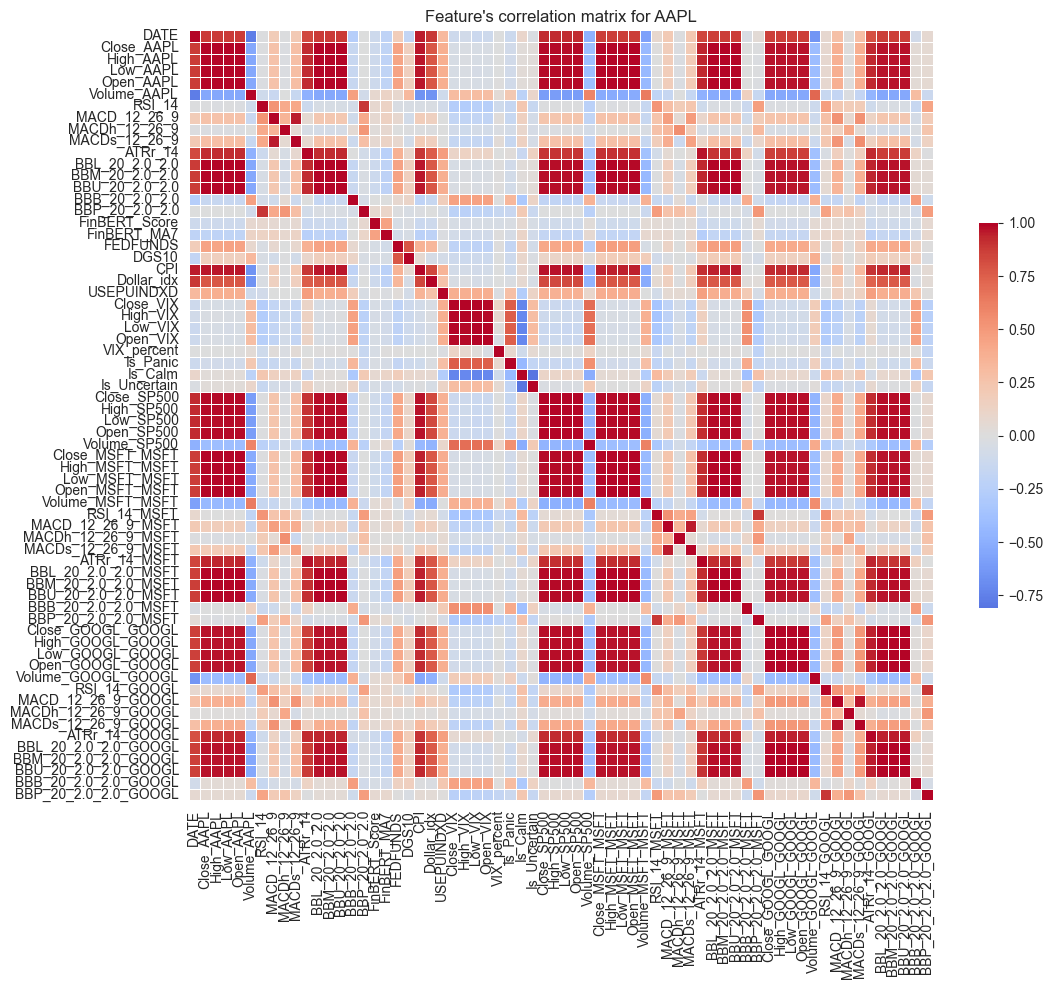

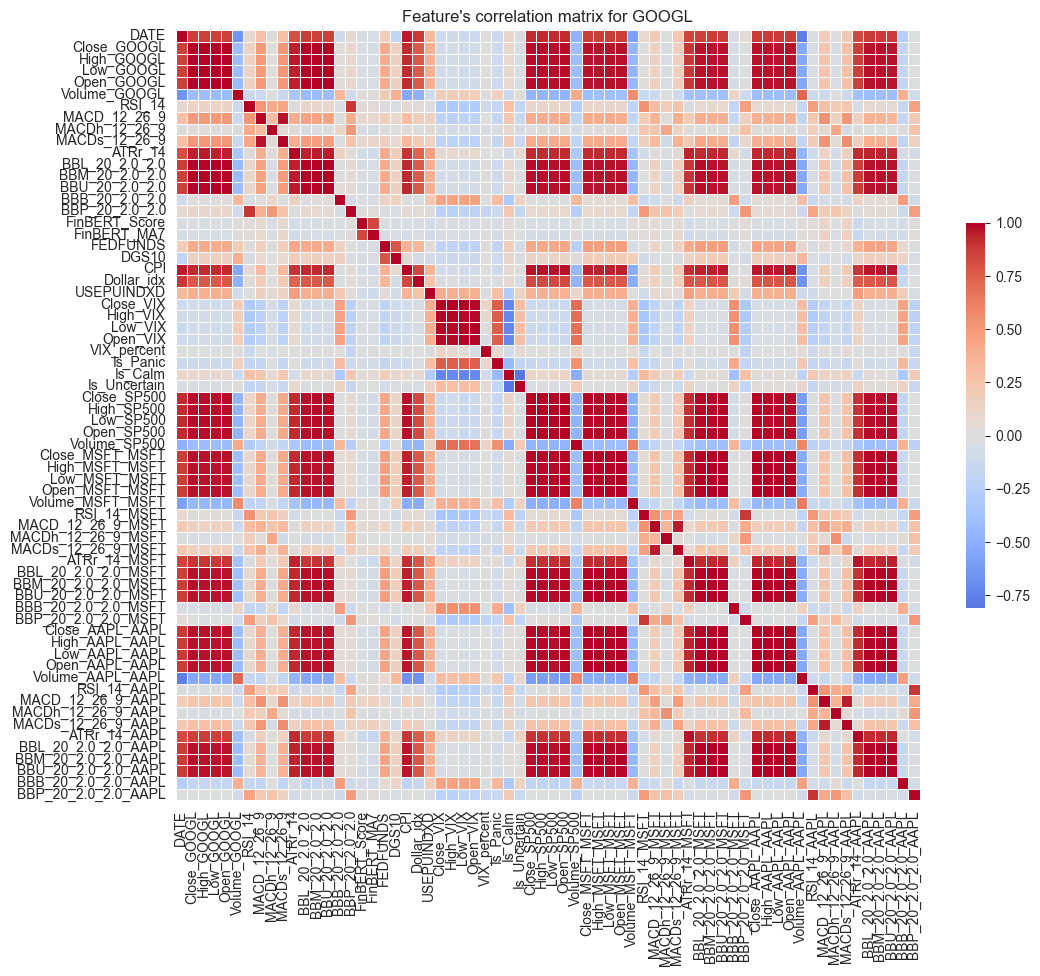

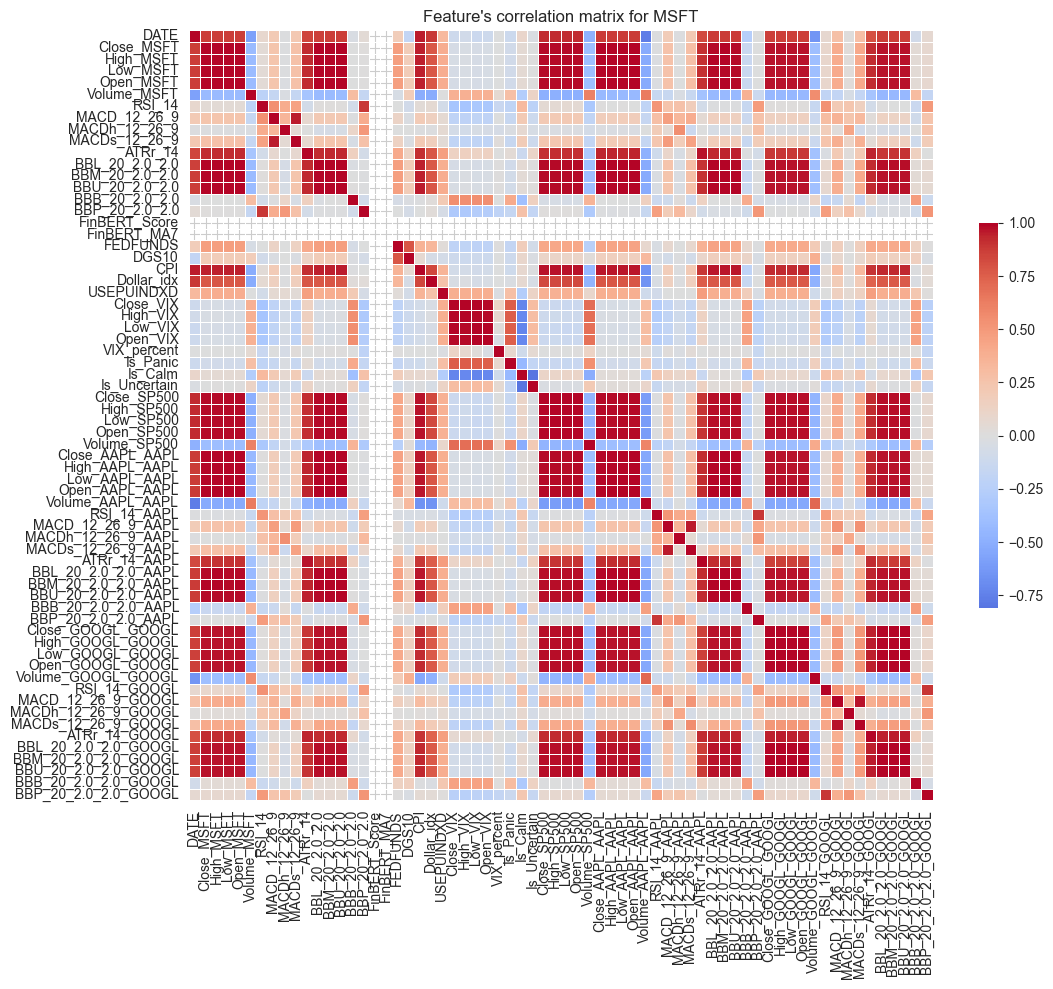

In [83]:
#### HEATMAP OF CORRELACTION  MATRIX
for share in tickers:
    data = stock_dfs[share]
    corr_matrix = data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, 
                annot=False,     
                cmap='coolwarm',    
                center=0, 
                linewidths=.5,
                cbar_kws={"shrink": .5},
                xticklabels=True,    
                yticklabels=True)
    
    plt.title(f"Feature's correlation matrix for {share}")
    plt.savefig(f'Feature_corr_matrix_for_{share}.png')
    plt.show()